#### Importing Required Packages

In [6]:
import pandas as pd
pd.options.mode.chained_assignment = None
import plotly.express as px

import lmfit
from scipy.integrate import odeint

## Importing the Covid-19 Statistics dataset by Covid Tracking Projects

In [7]:
covid_stats=pd.read_csv("../covid-statistics-by-us-states-daily-updates.csv")

## Preprocessing the data set
- Filtering and retrieving New York data only.
- Dropping Unnecessary Comuns.
- Sorting the rows with respect to the date.
- Deaths, Recovered and Positives have NAN before the first recorded Death, Recovery and Positive respectively. Changing these NAN values to 0.

In [8]:

covid_stats=covid_stats[covid_stats.state=='NY']
covid_stats=covid_stats.drop(['Unnamed: 0', 'posneg', 'pending', 'hash','commercialscore', 'negativeregularscore',
                             'negativescore', 'positivescore', 'grade', 'score','state','dataqualitygrade',
                              'lastupdateet', 'datemodified','checktimeet', 'datechecked', 'fips', 'hash',
                              'commercialscore','negativeregularscore', 'negativescore', 'positivescore',
                              'score', 'grade','onventilatorcumulative','deathconfirmed','deathprobable',
                             'inicucumulative','negativetestsviral','positivetestsviral', 'totaltestsviral',
                              'positivecasesviral','deathincrease','hospitalizedcurrently','inicucurrently',
                             'onventilatorcurrently'], 
                             axis=1).sort_values('date')
covid_stats = covid_stats.fillna(0)
covid_stats

,date,positive,negative,hospitalizedcumulative,recovered,death,hospitalized,positiveincrease,negativeincrease,total,totaltestresults,totaltestresultsincrease,hospitalizedincrease
8138,2020-03-04,6.0,48.0,0.0,0.0,0.0,0.0,0,0,78,54,0,0
8120,2020-03-05,22.0,76.0,0.0,0.0,0.0,0.0,16,28,122,98,44,0
8093,2020-03-06,33.0,92.0,0.0,0.0,0.0,0.0,11,16,361,125,27,0
8053,2020-03-07,76.0,92.0,0.0,0.0,0.0,0.0,43,0,404,168,43,0
8003,2020-03-08,105.0,92.0,0.0,0.0,0.0,0.0,29,0,197,197,29,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,2020-07-25,411200.0,5105111.0,89995.0,72632.0,25103.0,89995.0,750,70716,5516311,5516311,71466,0
205,2020-07-26,411736.0,5158143.0,89995.0,72716.0,25106.0,89995.0,536,53032,5569879,5569879,53568,0
149,2020-07-27,412344.0,5214805.0,89995.0,72766.0,25117.0,89995.0,608,56662,5627149,5627149,57270,0
93,2020-07-28,412878.0,5271668.0,89995.0,72813.0,25126.0,89995.0,534,56863,5684546,5684546,57397,0


Storing Active cases, Deaths, Recovered and Positive cases in separate numpy arrays.

In [11]:
active = covid_stats['positive'].values - covid_stats['recovered'].values - covid_stats['death'].values
deaths = covid_stats['death'].values
recovered = covid_stats['recovered'].values
positive = covid_stats['positive'].values

## Plotting Cumulative positive cases in time in New York.

In [17]:
fig = px.line(x=covid_stats['date'],
              y=positive,
              title='Positive cases',
              labels={'x': 'Days','y': "Cumulative Positive cases"})
fig.show()

## Plotting Cumulative Deaths in time in New York.

In [18]:
fig = px.line(x=covid_stats['date'],
              y=deaths,
              title='Deaths',
              labels={'x': 'Days','y': "Cumulative Deaths"})
fig.show()

## Deriving the Equations defining the Coronavirus SIR model

In the next programming cell we define a set of equations that can model the Corona virus pandemic.<br/>
<br/>
we use 6 different stages:
    - S --> Susceptible Stage
    - E --> Exposed Stage
    - I --> Infected Stage
    - R --> Recovered Stage
    - C --> Critical Stage
    - D --> Dead Stage
    
We now need to Derive equations which can define the change in population at each stage.
<br/>
<br/>
We derive the following Equations:
    - dSdt --> Change in Susceptible population
    
$\begin{aligned}
    \frac{dS}{dt}=\beta * \frac{S}{N} * I\\
    \end{aligned}$
    
    - dEdt --> Change in Exposed population -->
    
$\begin{aligned}
    \frac{dE}{dt}= (\beta * \frac{S}{N} * I) - (\sigma * 1 * E)\\
    \end{aligned}$
    
    - dIdt --> Change in Infected population -->
    
$\begin{aligned}
    \frac{dI}{dt}= (\sigma * 1 * E) - (Rate of I to C * Probability of I to C * I) - (\gamma*(1-Probability of I to C)*I)\\
    \end{aligned}$    
    
    - dRdt --> Change in Recovered population -->
    
$\begin{aligned}
    \frac{dC}{dt}= (Rate of I to C * Probability of I to C * I) - (Rate of C to D * Probability of C to D * C) - (Rate of C to R * (1-Probability of C to D) * C)\\
    \end{aligned}$ 
    
    - dCdt --> Change in Critical population -->
    
$\begin{aligned}
    \frac{dR}{dt}= (\gamma*(1-Probability of I to C)*I) + (Rate of C to R * (1-Probability of C to D) * C)\\
    \end{aligned}$    
    
    - dDdt --> Change in Dead population -->
    
$\begin{aligned}
    \frac{dR}{dt}= (Rate of C to D * Probability of C to D * C)\\
    \end{aligned}$ 

We now Implemetnt these Equationd as a method deriv.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# The SIR model differential equations.
def deriv(y, t, beta, r_I_to_C, r_C_to_D, r_C_to_R, gamma, sigma, N, prob_I_to_C, prob_C_to_D):
    S, E, I, C, R, D = y
    
    dSdt = -beta(t)*I*S/N
    dEdt = beta(t)*I*S/N - sigma*1*E
    dIdt = (sigma*1*E) - (r_I_to_C*prob_I_to_C*I) - (gamma*(1-prob_I_to_C)*I)
    dCdt = (r_I_to_C*prob_I_to_C*I) - (r_C_to_D*prob_C_to_D*C) - (r_C_to_R*(1-prob_C_to_D)*C) 
    dRdt = (gamma*(1-prob_I_to_C)*I) + r_C_to_R*(1-prob_C_to_D)*C
    dDdt = (r_C_to_D*prob_C_to_D*C)
    return dSdt, dEdt, dIdt, dCdt, dRdt, dDdt

In [12]:
days = 148

def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def Model(r_I_to_C, r_C_to_D, r_C_to_R, gamma, sigma,
          R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D):

    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma
    
    # Total population, N.
    N = 19453556
    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days-1, days)
#     print(t)
    ret = odeint(deriv, y0, t, args=(beta, r_I_to_C, r_C_to_D, r_C_to_R, gamma,
                                     sigma, N, prob_I_to_C, prob_C_to_D))
    S, E, I, C, R, D = ret.T
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]
    
    return t, S, E, I, C, R, D, R_0_over_time, prob_I_to_C, prob_C_to_D

In [13]:
params_init_min_max = {"gamma":(1.0/9.0, 1.0/13.0, 1.0/5.0),"sigma":(1.0/3.0, 1.0/4.0, 1.0/2.0),
                       "R_0_start":(3.0, 2.0, 5.0), "k":(2.5, 0.01, 5.0), "x0": (90, 0, 120),
                       "R_0_end":(0.9, 0.3, 3.5), "prob_I_to_C":(0.05, 0.01, 0.1), "prob_C_to_D":(0.5, 0.05, 0.8),
                      "r_I_to_C":(1.0/12.0, 1.0/13.0, 1.0/10.0),"r_C_to_D":(1.0/7.5, 1.0/9.0, 1.0/6.0),
                      "r_C_to_R":(1.0/6.5, 1.0/8.0, 1.0/5.0)}

In [14]:
def fitter(x, r_I_to_C, r_C_to_D, r_C_to_R, gamma, sigma, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D):
    ret = Model(r_I_to_C, r_C_to_D, r_C_to_R, gamma, sigma, R_0_start, k, x0,
                R_0_end, prob_I_to_C, prob_C_to_D)
    return ret[6][x]

In [15]:
mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
#     print(kwarg)
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
# print(params)
fit_method = "leastsq"

In [16]:
x_data = np.linspace(0, days - 1, days, dtype=int)
y_data = deaths
result = mod.fit(y_data, params, method="least_squares", x=x_data)

/Users/abdulrehman/opt/anaconda3/lib/python3.7/site-packages/lmfit/minimizer.py:779: RuntimeWarning:

invalid value encountered in sqrt

/Users/abdulrehman/opt/anaconda3/lib/python3.7/site-packages/lmfit/minimizer.py:786: RuntimeWarning:

invalid value encountered in sqrt



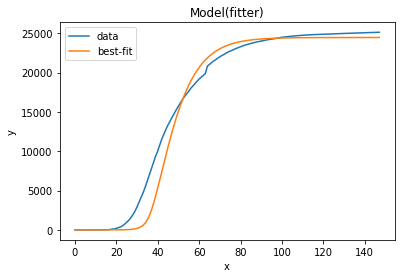

In [17]:
result.plot_fit(datafmt="-");

/Users/abdulrehman/opt/anaconda3/lib/python3.7/site-packages/lmfit/minimizer.py:779: RuntimeWarning:

invalid value encountered in sqrt

/Users/abdulrehman/opt/anaconda3/lib/python3.7/site-packages/lmfit/minimizer.py:786: RuntimeWarning:

invalid value encountered in sqrt



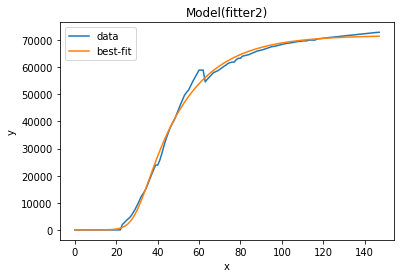

In [18]:
def fitter2(x, r_I_to_C, r_C_to_D, r_C_to_R, gamma, sigma, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D):
    ret = Model(r_I_to_C, r_C_to_D, r_C_to_R, gamma, sigma, R_0_start, k, x0,
                R_0_end, prob_I_to_C, prob_C_to_D)
    return ret[5][x]
mod2 = lmfit.Model(fitter2)
for kwarg, (init, mini, maxi) in params_init_min_max.items():
#     print(kwarg)
    mod2.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)
params2 = mod2.make_params()
x_data = np.linspace(0, days - 1, days, dtype=int)
y_data = recovered
result2 = mod2.fit(y_data, params2, method="least_squares", x=x_data)
result2.plot_fit(datafmt="-");

In [19]:
result.best_values

{'r_I_to_C': 0.09999999999999878,
 'r_C_to_D': 0.16666666666666455,
 'r_C_to_R': 0.1250000005073413,
 'gamma': 0.1999999999999943,
 'sigma': 0.49999999999999556,
 'R_0_start': 4.999999999999977,
 'k': 4.999999999972436,
 'x0': 34.21139651518747,
 'R_0_end': 0.3411250602154743,
 'prob_I_to_C': 0.09999999999999708,
 'prob_C_to_D': 0.7999999999999936}

In [20]:
result2.best_values

{'r_I_to_C': 0.0769230769230773,
 'r_C_to_D': 0.16666666666661534,
 'r_C_to_R': 0.19999999999999998,
 'gamma': 0.19999999999999993,
 'sigma': 0.49999999999992856,
 'R_0_start': 4.999999999997509,
 'k': 0.3410795793116647,
 'x0': 26.30998673995726,
 'R_0_end': 0.6436672524582532,
 'prob_I_to_C': 0.09999999999993744,
 'prob_C_to_D': 0.0500000000000483}